步骤
1.图片数据预处理
2.加载模型
3.提取图片的特征描述符
4.预测图片：找到欧式距离最近的特征描述符
5.评估测试数据集

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import dlib

# %matplotlib inline
plt.rcParams['figure.dpi'] = 200

In [2]:
# 获取人脸68个关键点
hog_face_detector = dlib.get_frontal_face_detector()
# 关键点检测模型
shape_detector = dlib.shape_predictor('./weights/shape_predictor_68_face_landmarks.dat')

In [3]:
# 读取1张测试图片
img = cv2.imread('./images/others/Walid_Al-Awadi/Walid_Al-Awadi_0001.jpg')
# plt.imshow(img)
# 检测人脸
detections = hog_face_detector(img,1)

for face in detections:
    l,t,r,b = face.left(),face.top(),face.right(),face.bottom()

    # 获取68个关键点
    points = shape_detector(img,face)
    # 绘制关键点
    for point in points.parts():
        cv2.circle(img,(point.x,point.y),2,(0,255,0),1)
    # 绘制矩形框
    cv2.rectangle(img,(l,t),(r,b),(255,0,0),2)

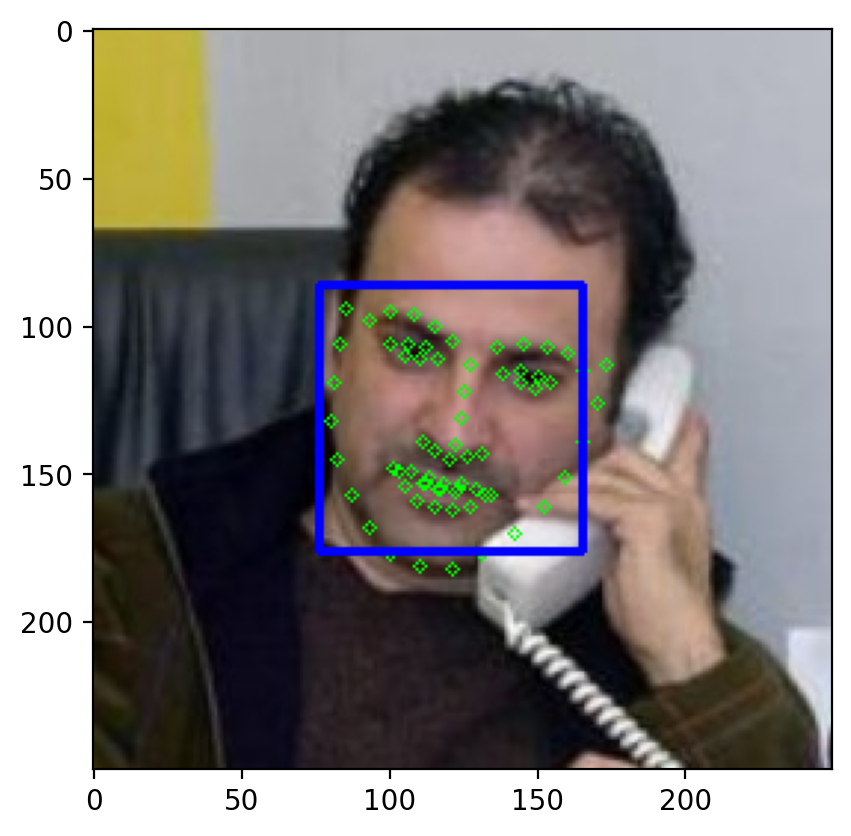

In [4]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [5]:
# 面部特征描述符
# 获取人脸68个关键点
hog_face_detector = dlib.get_frontal_face_detector()
# 关键点检测模型
shape_detector = dlib.shape_predictor('./weights/shape_predictor_68_face_landmarks.dat')
# resent模型
face_descriptor_extractor = dlib.face_recognition_model_v1('./weights/dlib_face_recognition_resnet_model_v1.dat')

In [6]:
# 提取单张图片的特征描述符label
def getFaceFeatLabel(filename):
    label_id = int(filename.split('/')[-1].split('.')[0].split('subject')[-1])

    # 读取图片
    cap = cv2.VideoCapture(filename)
    ret,img = cap.read()

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 检测人脸
    detections = hog_face_detector(img, 1)

    face_decriptor = None
    for face in detections:
        # 获取关键点
        points = shape_detector(img,face)
        # 获取特征描述符
        face_decriptor = face_descriptor_extractor.compute_face_descriptor(img,points)
        # 转为numpy格式数组
        face_decriptor = [f for f in face_decriptor]
        face_decriptor = np.asarray(face_decriptor,dtype=np.float64)
        face_decriptor = np.reshape(face_decriptor,(1,-1))
        
    return label_id,face_decriptor
# img,label = getFaceImgLabel(img_path)
# plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [7]:
id1,fd1 = getFaceFeatLabel('./images/test/subject06.sad.gif')
fd1.shape

(1, 128)

In [8]:
# 遍历训练文件夹
import glob
file_list = glob.glob('./images/yalefaces/*.gif')
file_list = [file.replace('\\', '/') for file in file_list]

label_list = []
feature_list = None

name_list = {}
index = 0
for file in file_list:
    label, feature = getFaceFeatLabel(file)
    
    if feature is not None:
        # 文件名列表
        name_list[index] = file
        # label列表
        label_list.append(label)
        index += 1

        if feature_list is None:
            feature_list = feature
        else:    
            # 特征列表
            feature_list = np.concatenate((feature_list ,feature),axis=0)
            # feature_list = np.concatenate((feature_list, feature.reshape(1, -1)), axis=0)

# print(len(img_list),len(label_list))
print(name_list)

{0: './images/yalefaces/subject01.gif', 1: './images/yalefaces/subject01.glasses.gif', 2: './images/yalefaces/subject01.happy.gif', 3: './images/yalefaces/subject01.leftlight.gif', 4: './images/yalefaces/subject01.noglasses.gif', 5: './images/yalefaces/subject01.normal.gif', 6: './images/yalefaces/subject01.sad.gif', 7: './images/yalefaces/subject01.sleepy.gif', 8: './images/yalefaces/subject01.surprised.gif', 9: './images/yalefaces/subject01.wink.gif', 10: './images/yalefaces/subject02.centerlight.gif', 11: './images/yalefaces/subject02.glasses.gif', 12: './images/yalefaces/subject02.happy.gif', 13: './images/yalefaces/subject02.leftlight.gif', 14: './images/yalefaces/subject02.noglasses.gif', 15: './images/yalefaces/subject02.normal.gif', 16: './images/yalefaces/subject02.rightlight.gif', 17: './images/yalefaces/subject02.sad.gif', 18: './images/yalefaces/subject02.sleepy.gif', 19: './images/yalefaces/subject02.surprised.gif', 20: './images/yalefaces/subject02.wink.gif', 21: './image

In [9]:
# 计算距离
np.linalg.norm((feature_list[20]-feature_list[100]))

# 计算某个特征描述符与所有特征描述符的距离
np.linalg.norm((feature_list[100]-feature_list),axis=1)

# 寻找最小值索引

min_index = np.argmin(np.linalg.norm((feature_list[0]-feature_list[1:]),axis=1))
min_index

2

C:\Users\25194\AppData\Local\Temp\ipykernel_10264\3580086112.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


34
34


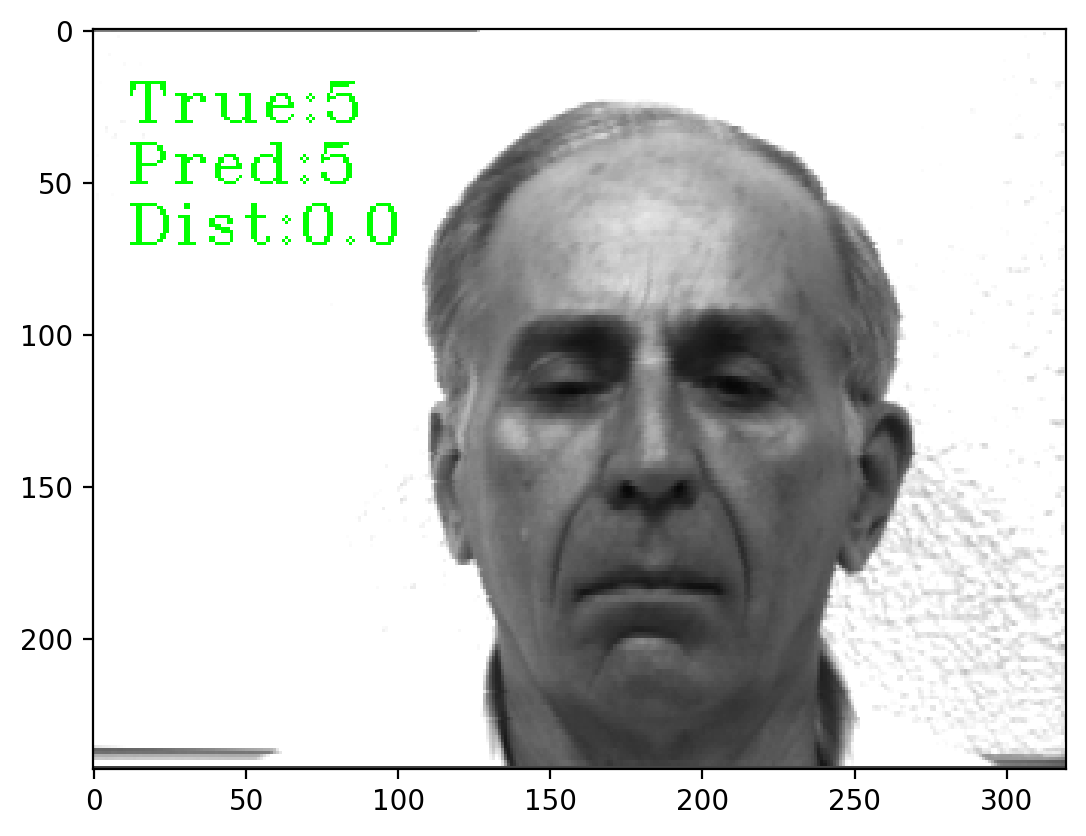

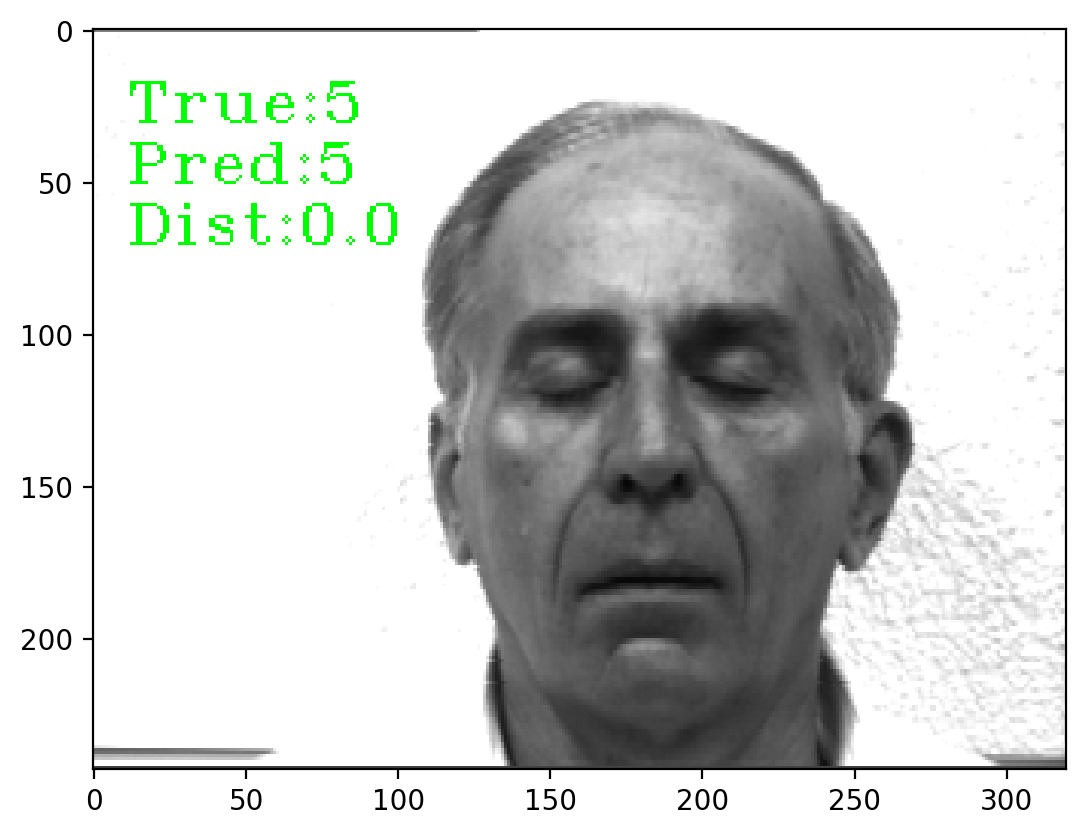

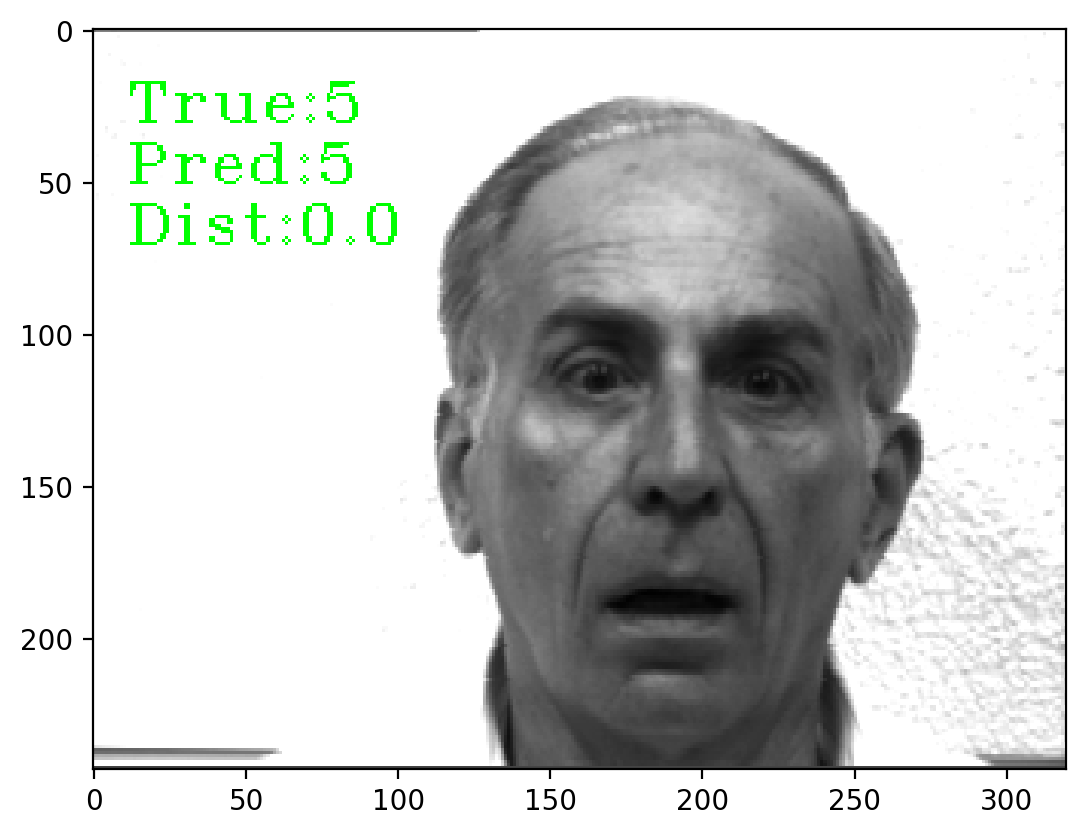

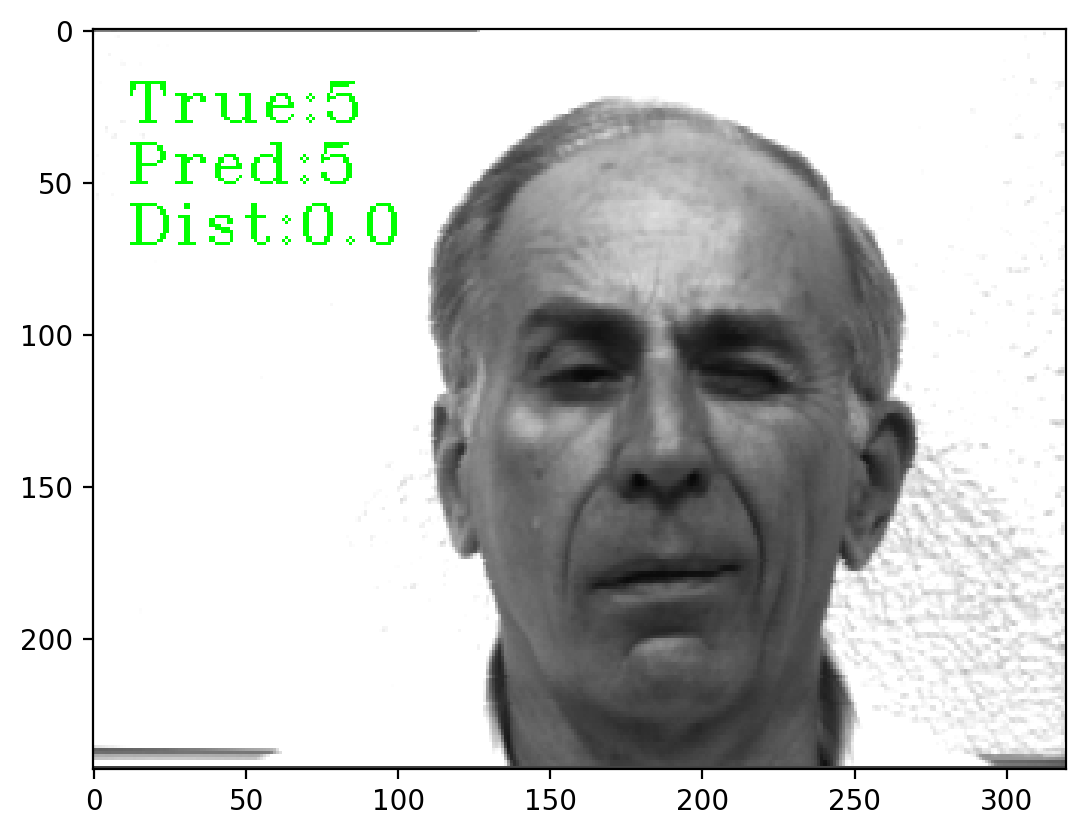

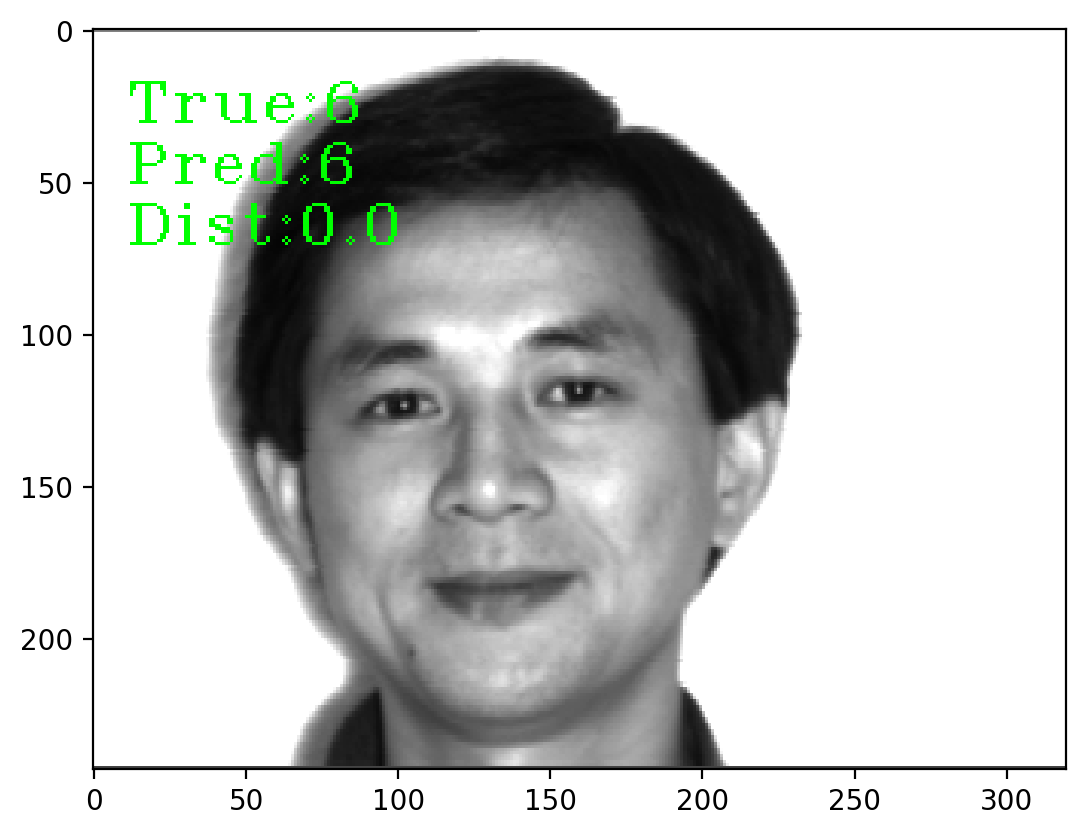

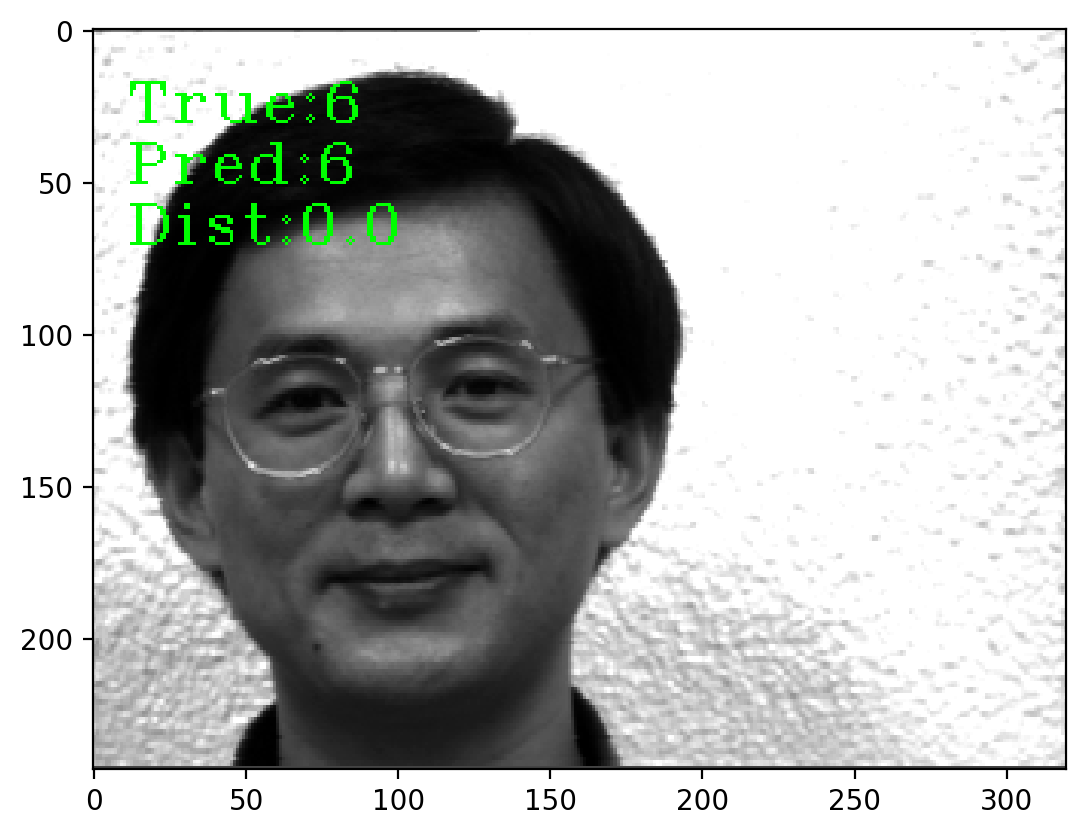

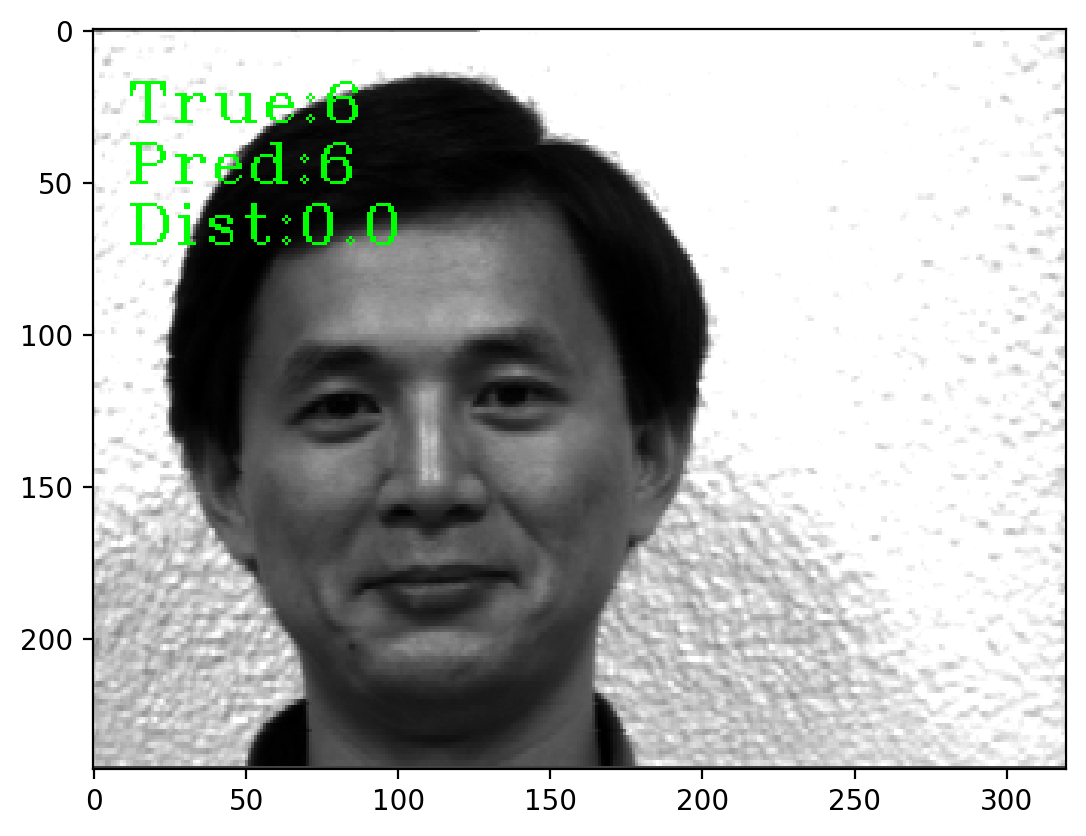

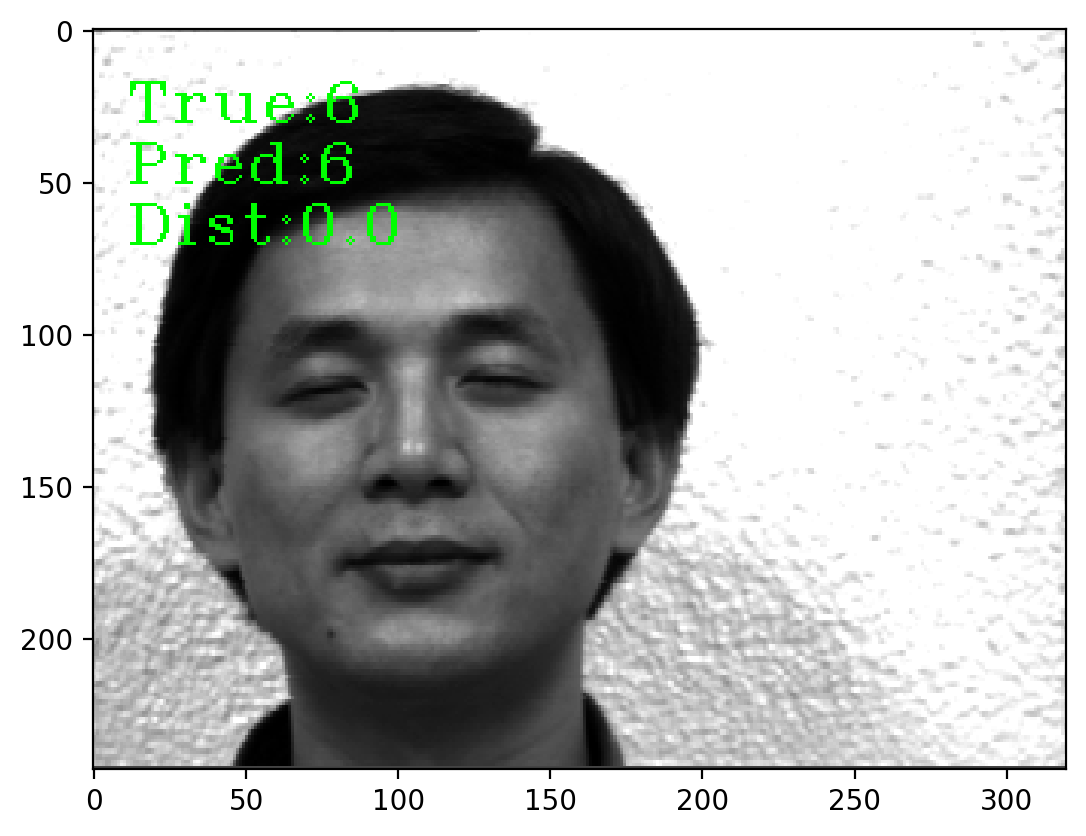

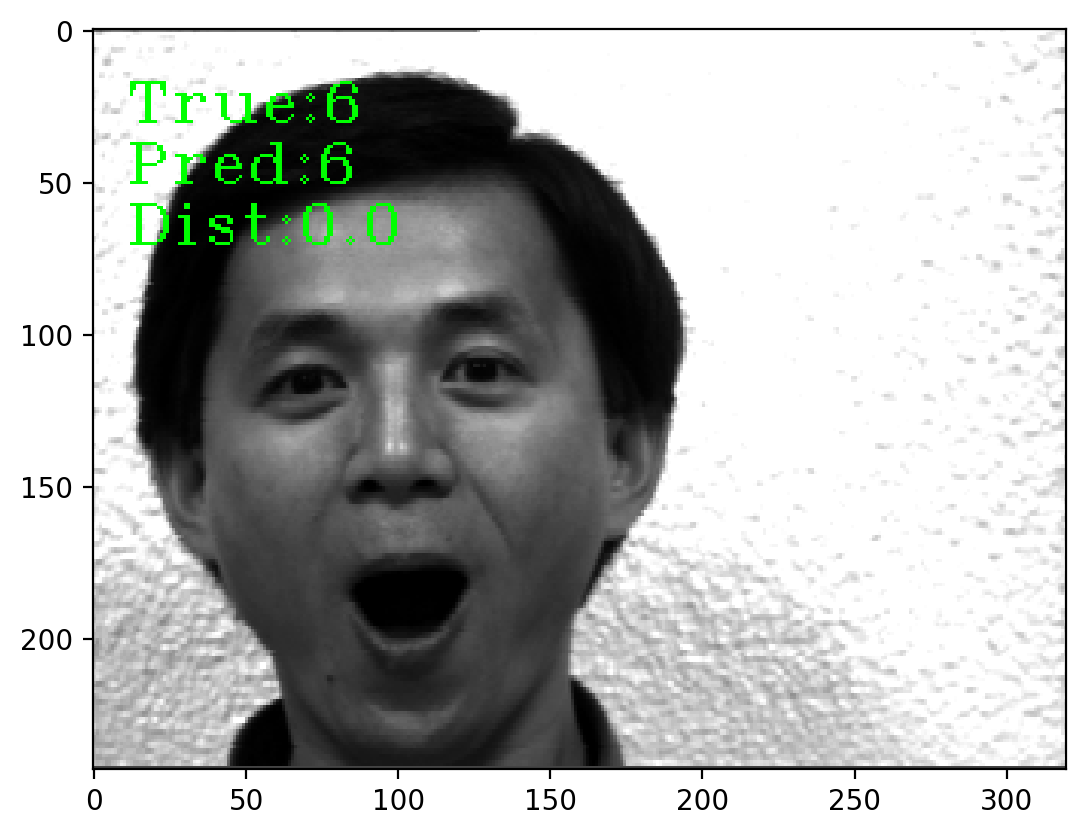

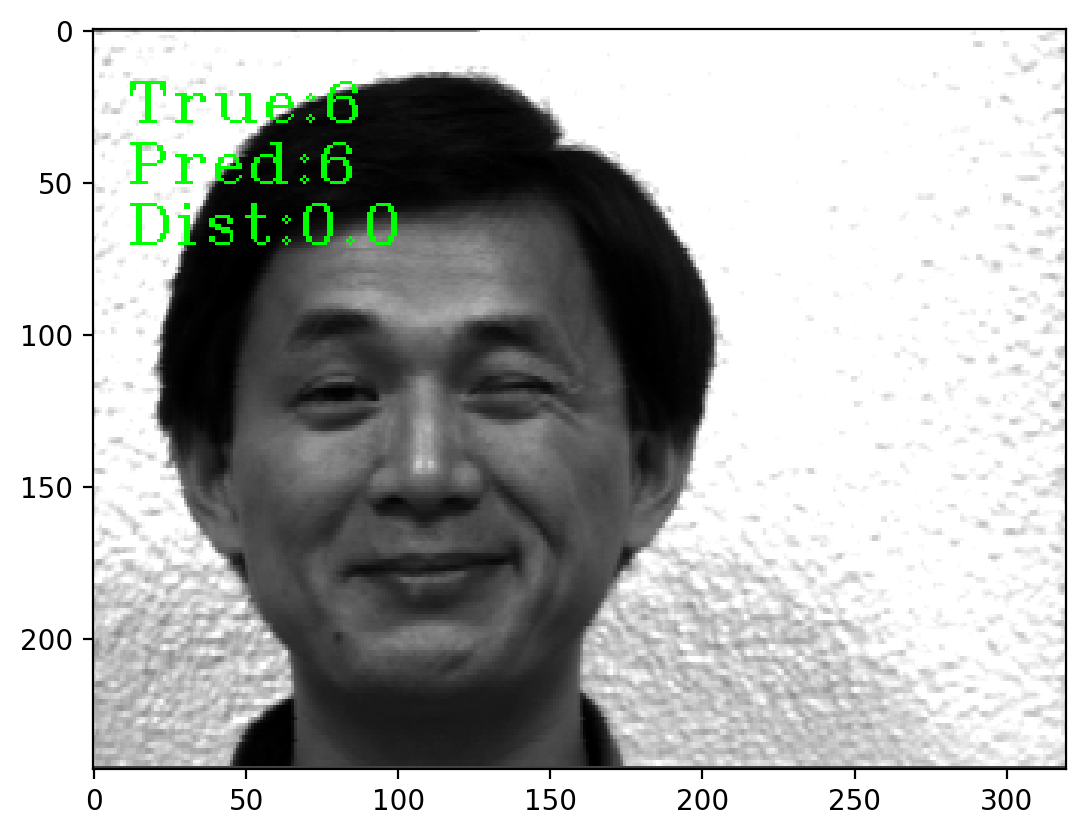

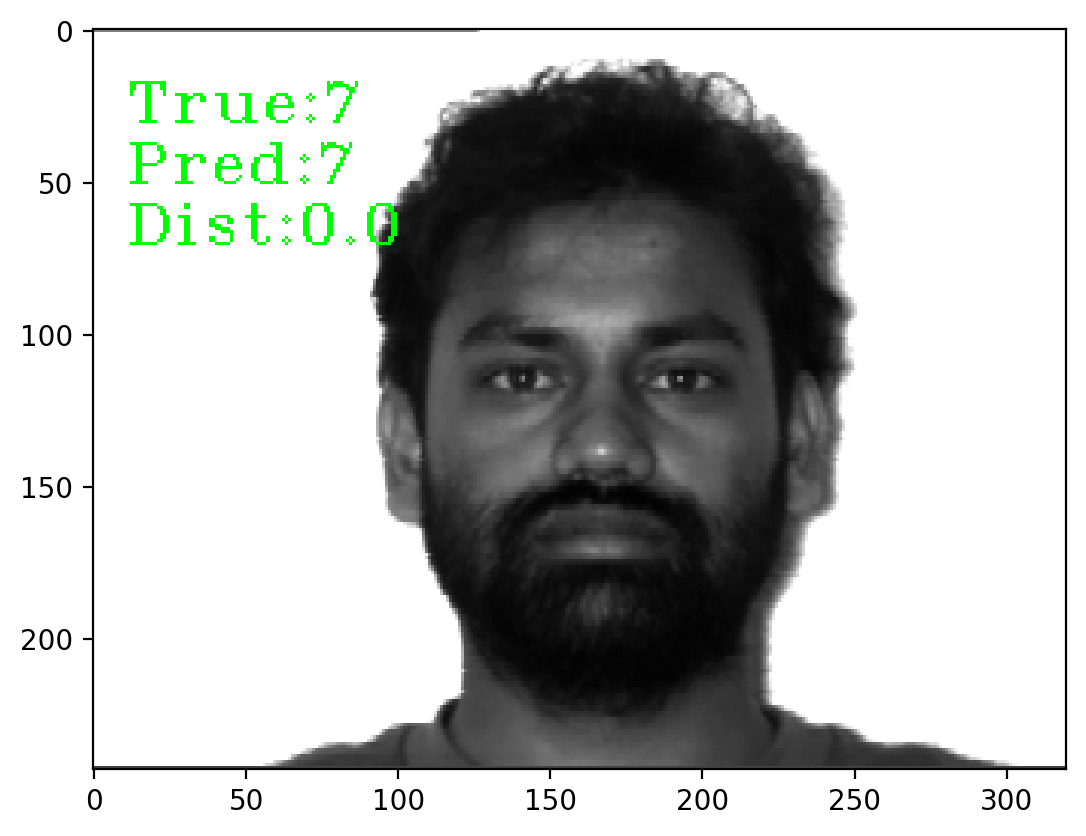

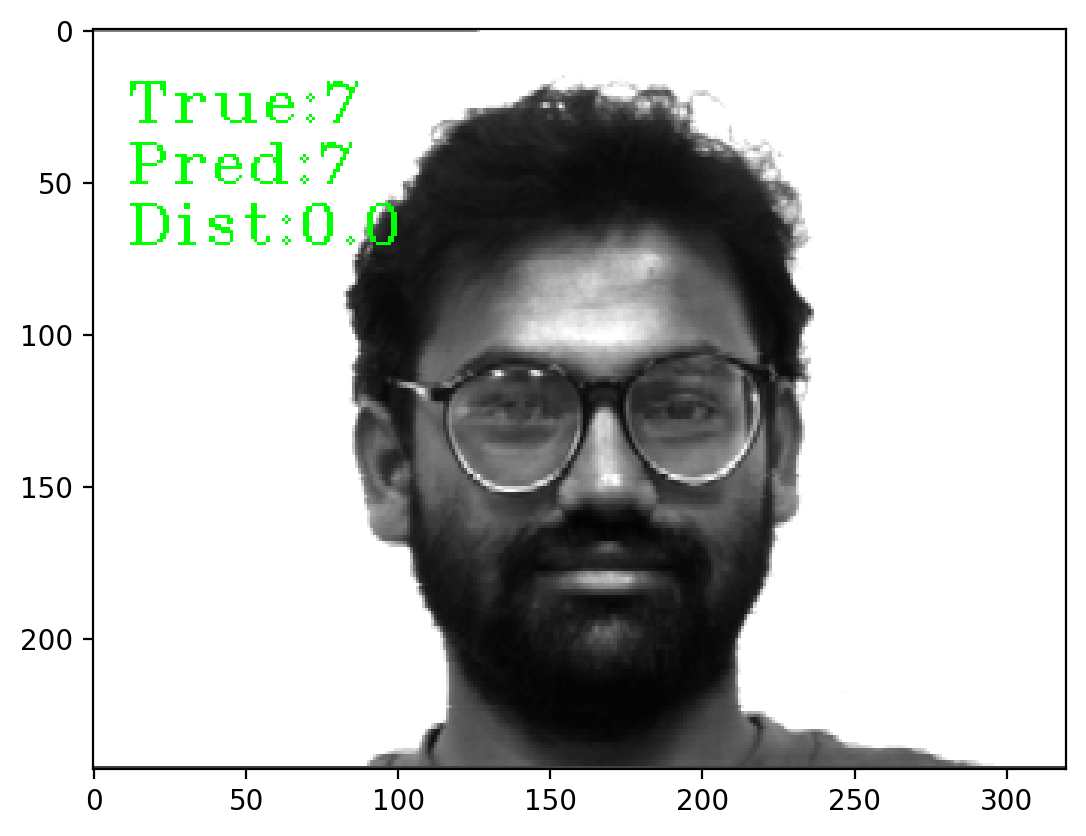

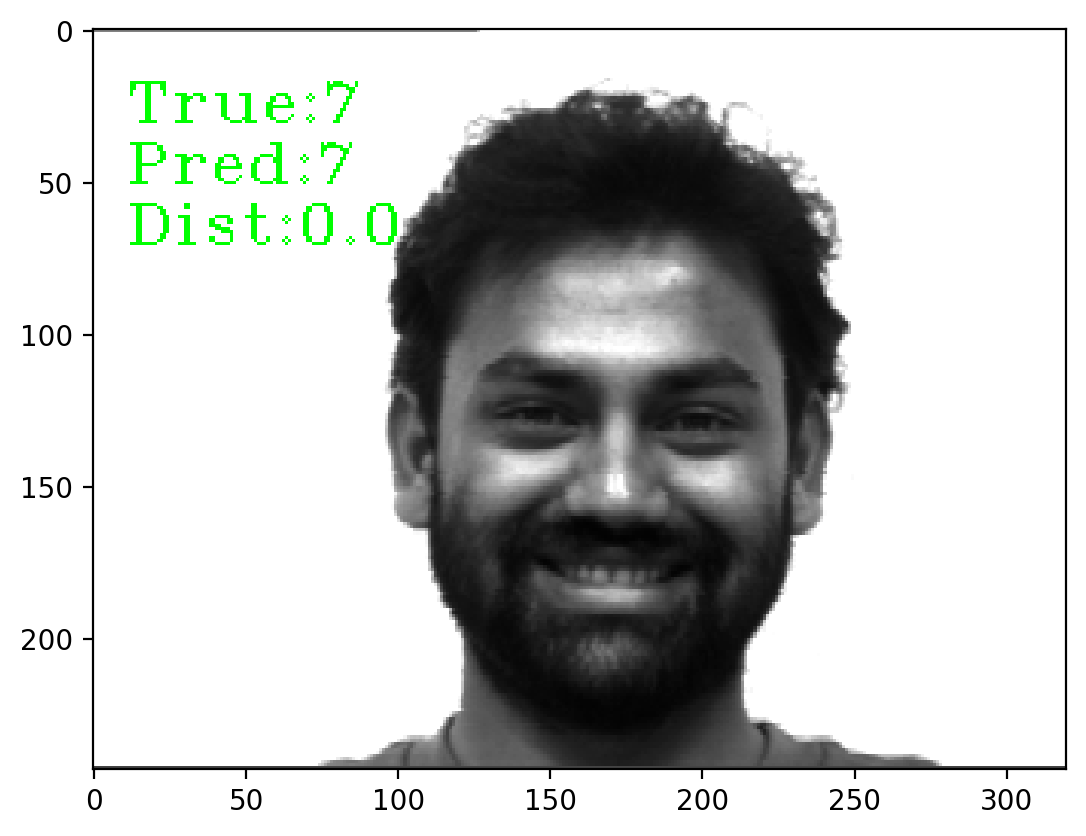

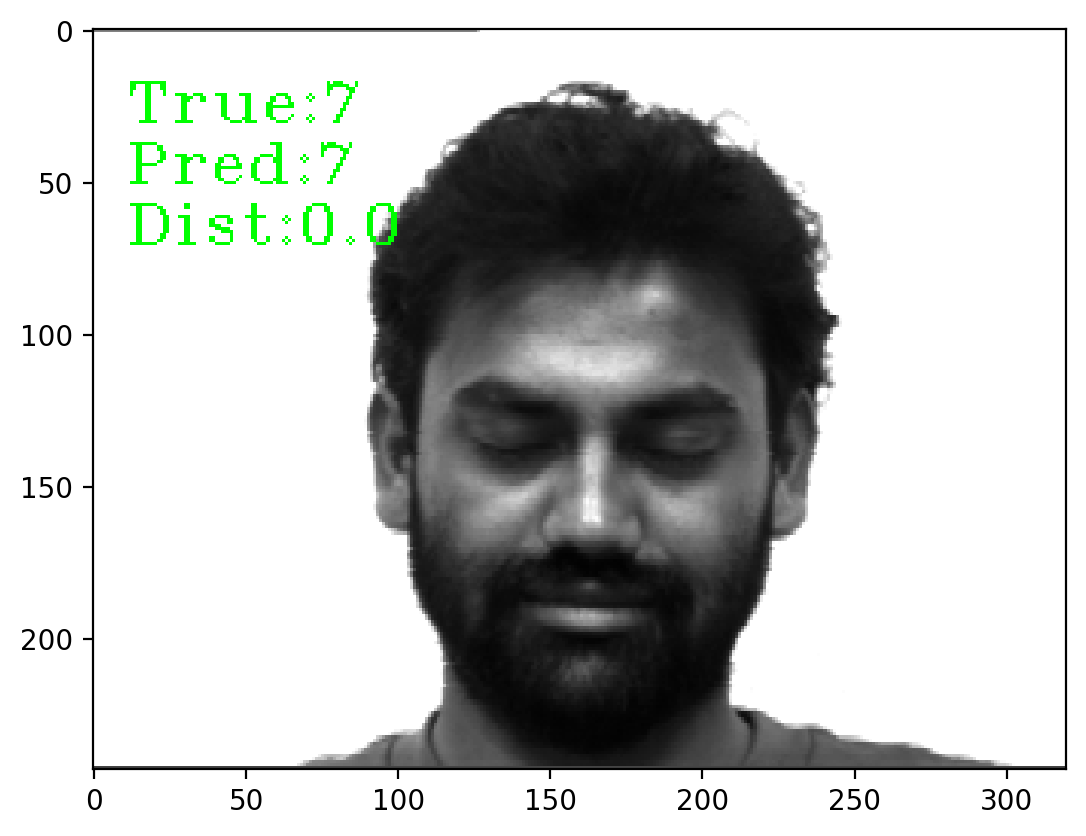

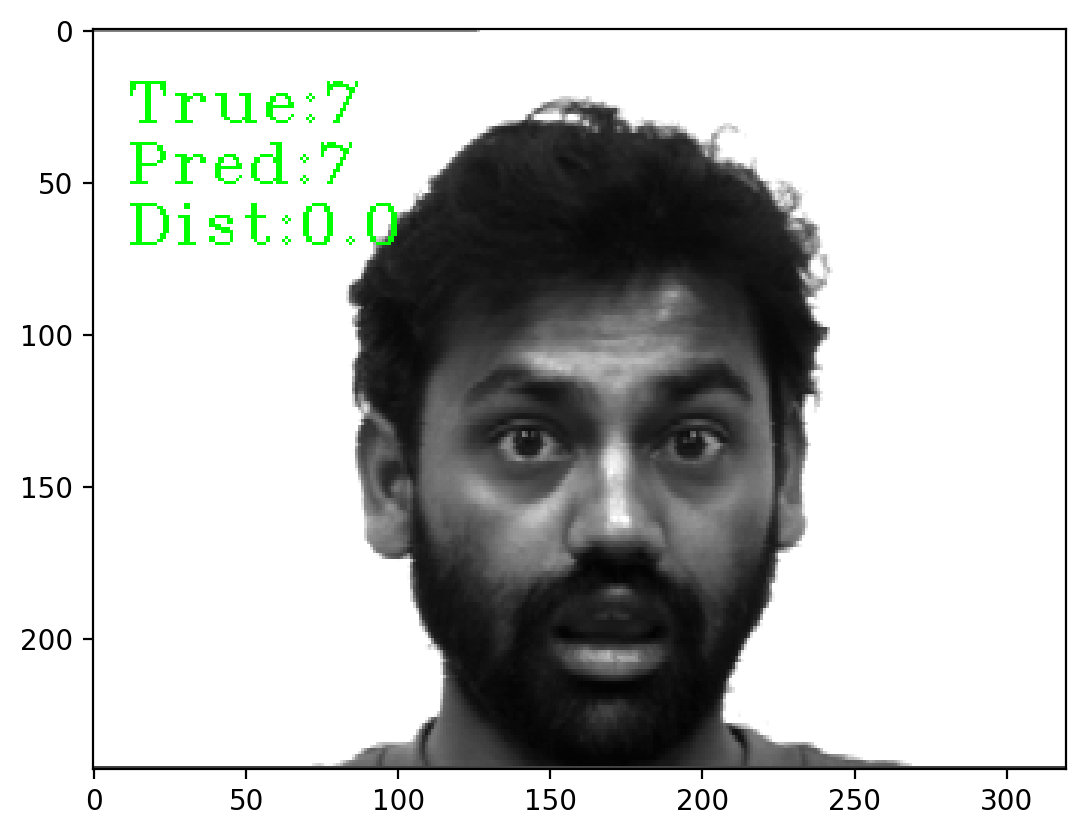

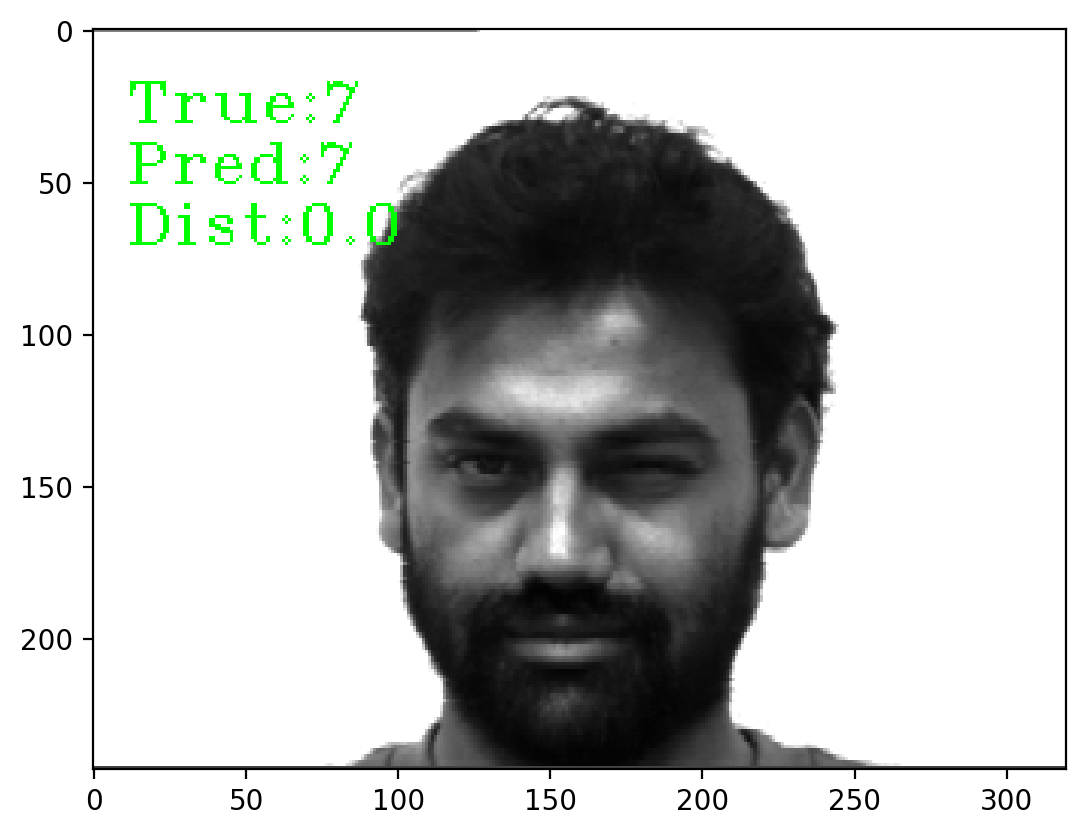

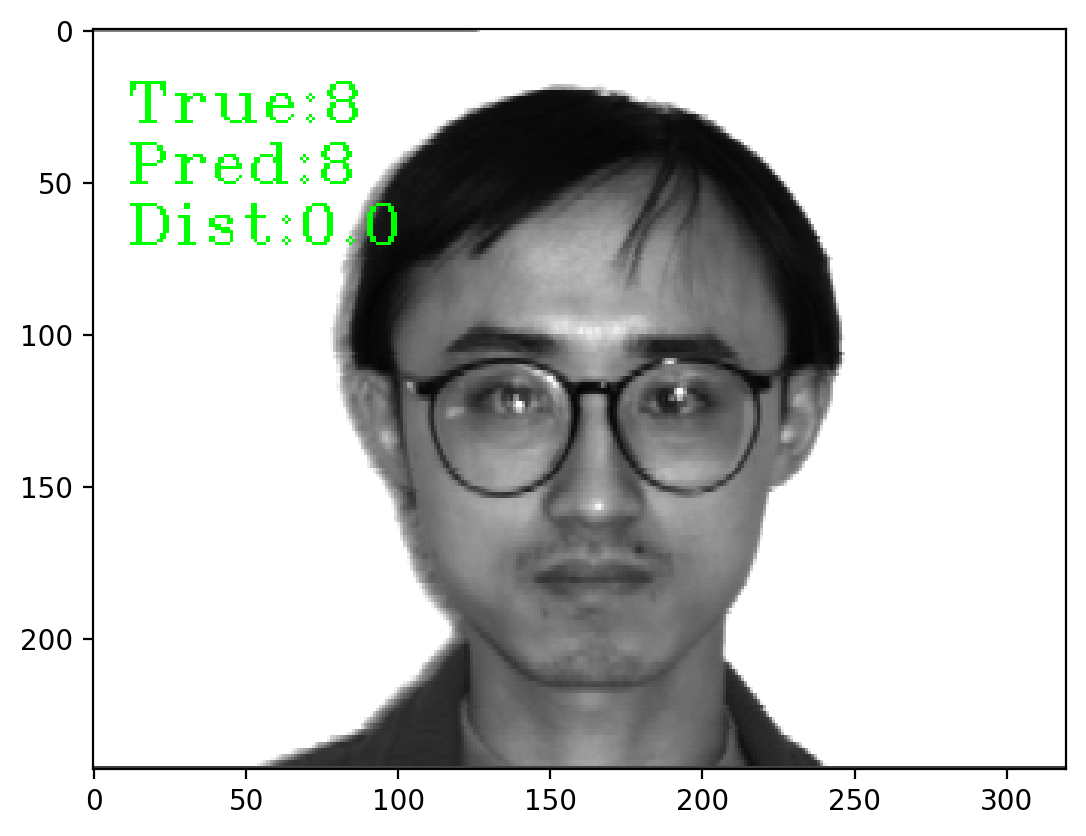

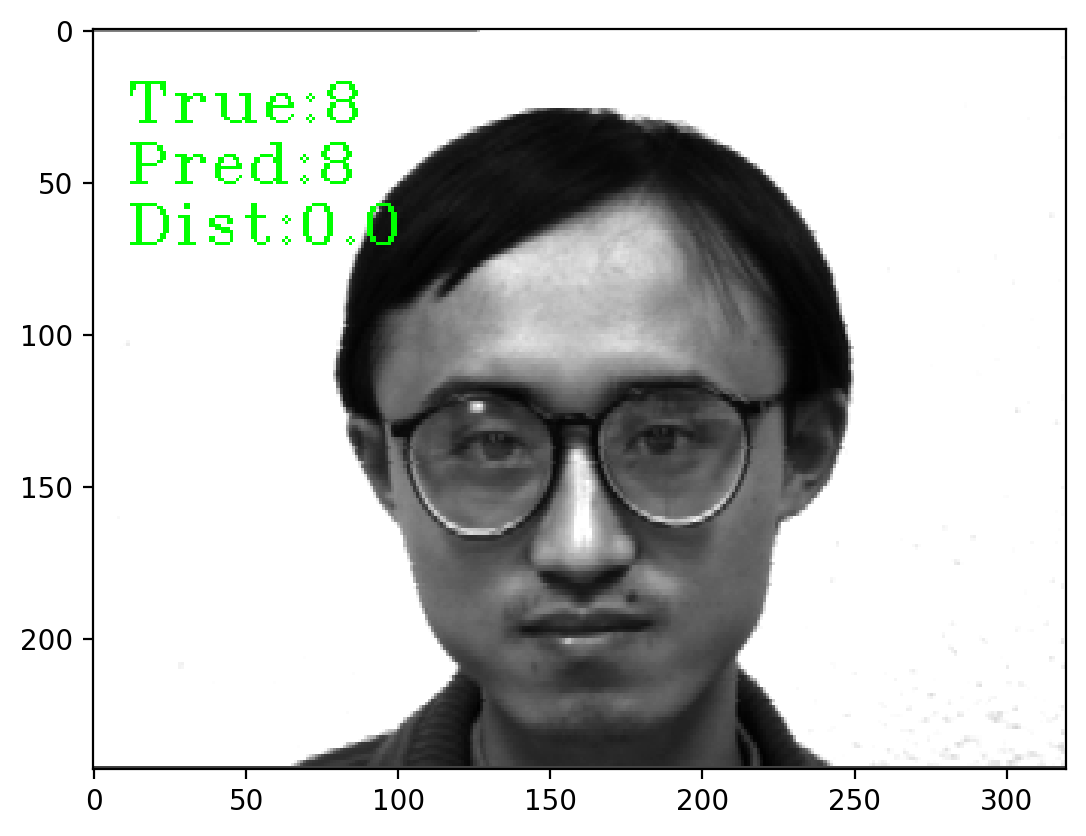

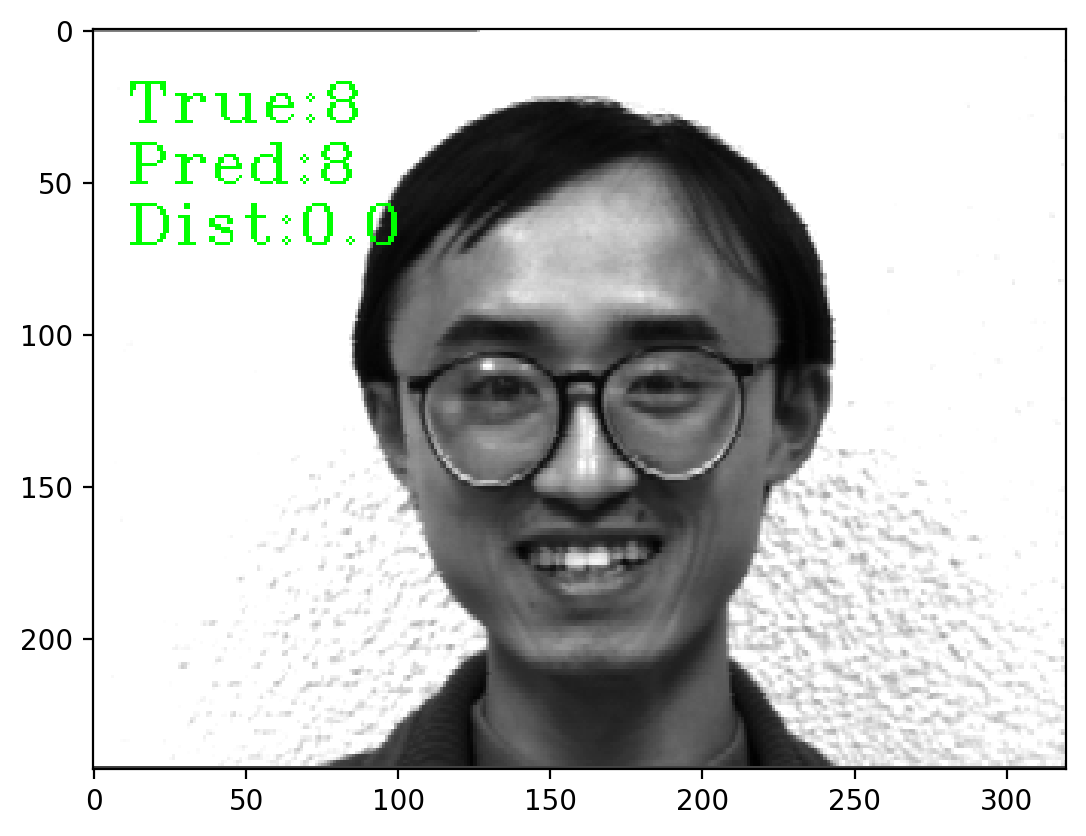

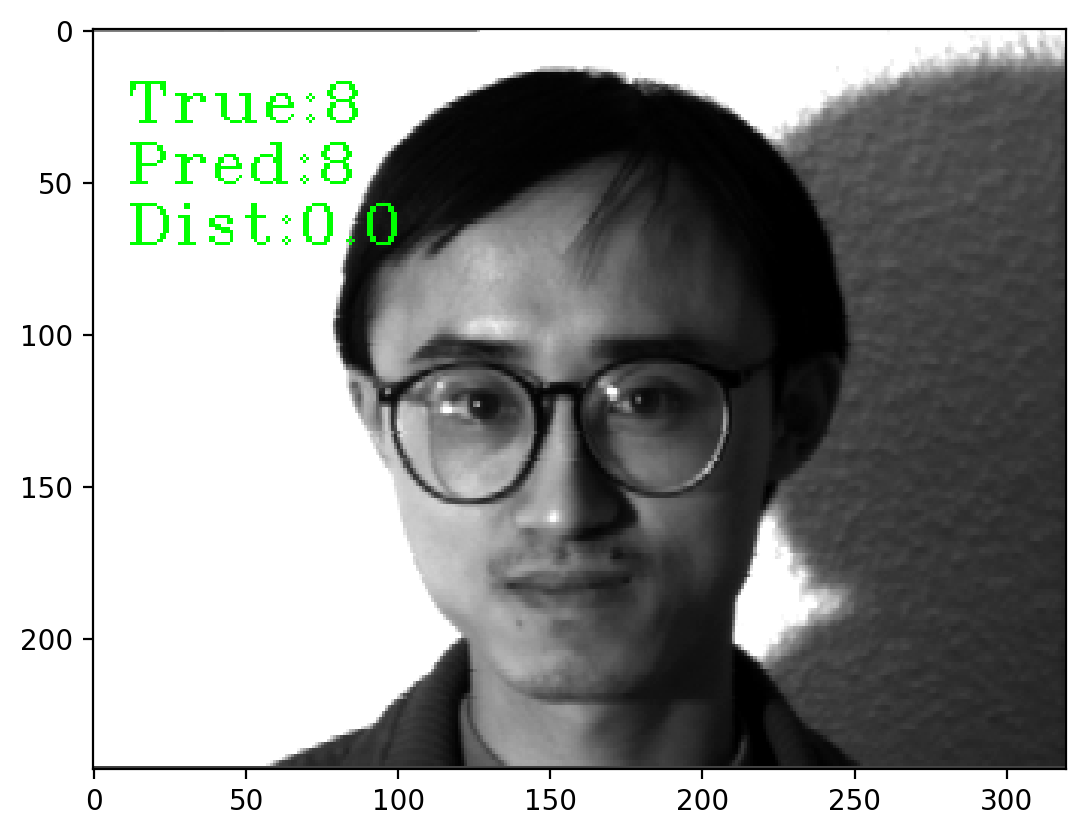

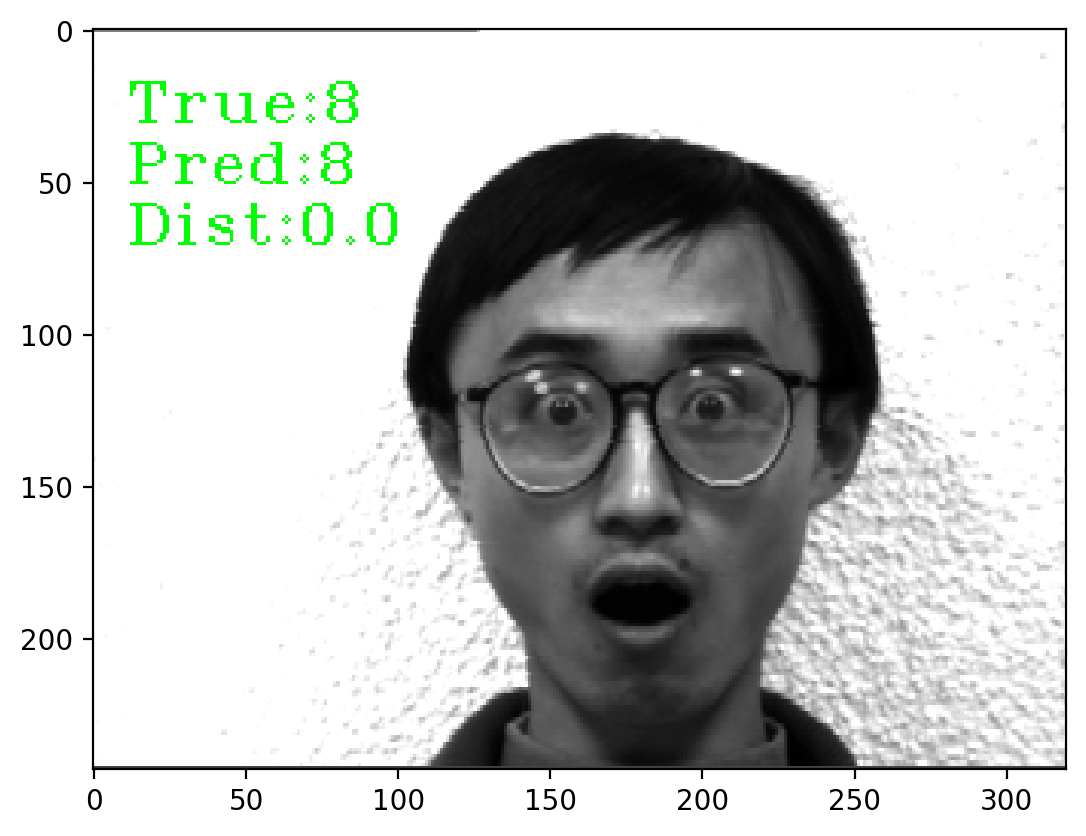

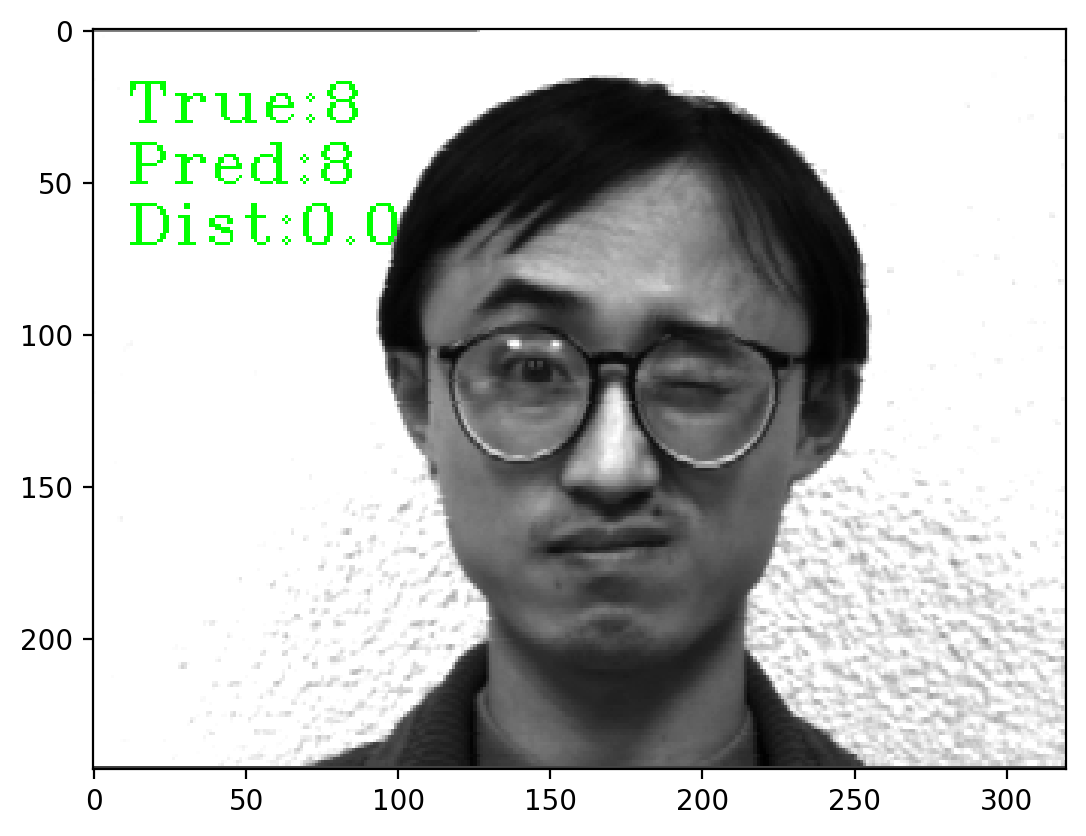

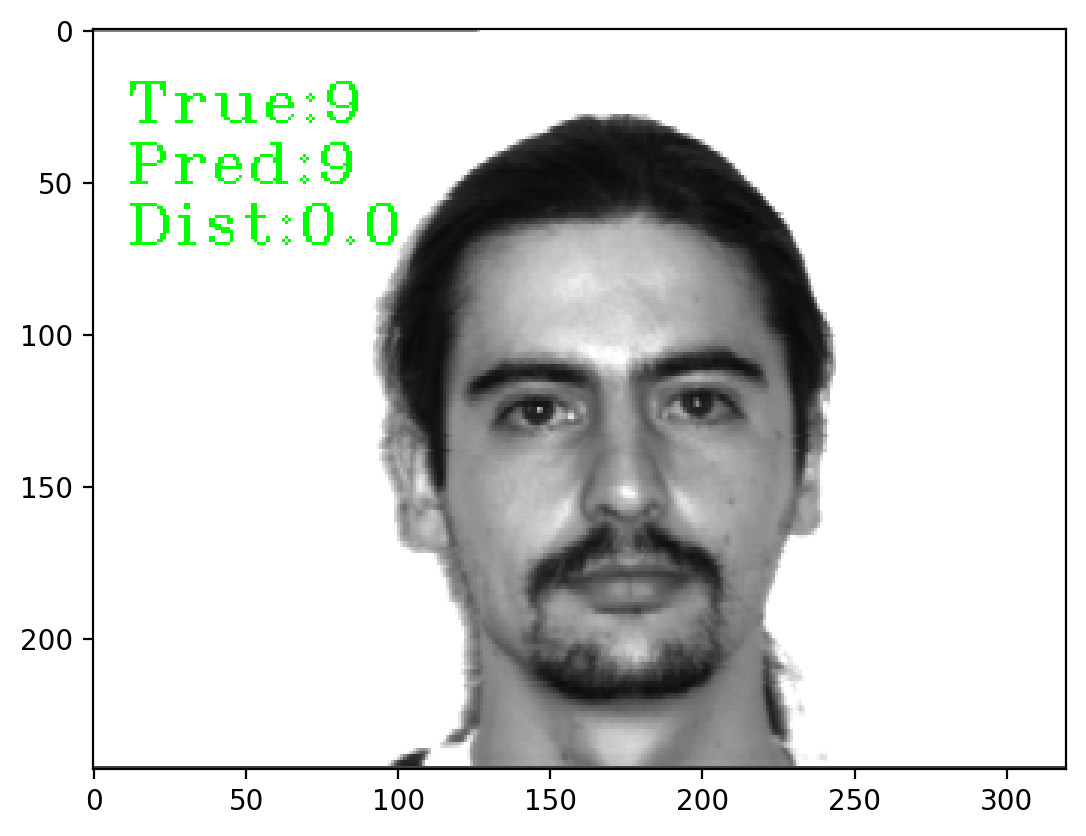

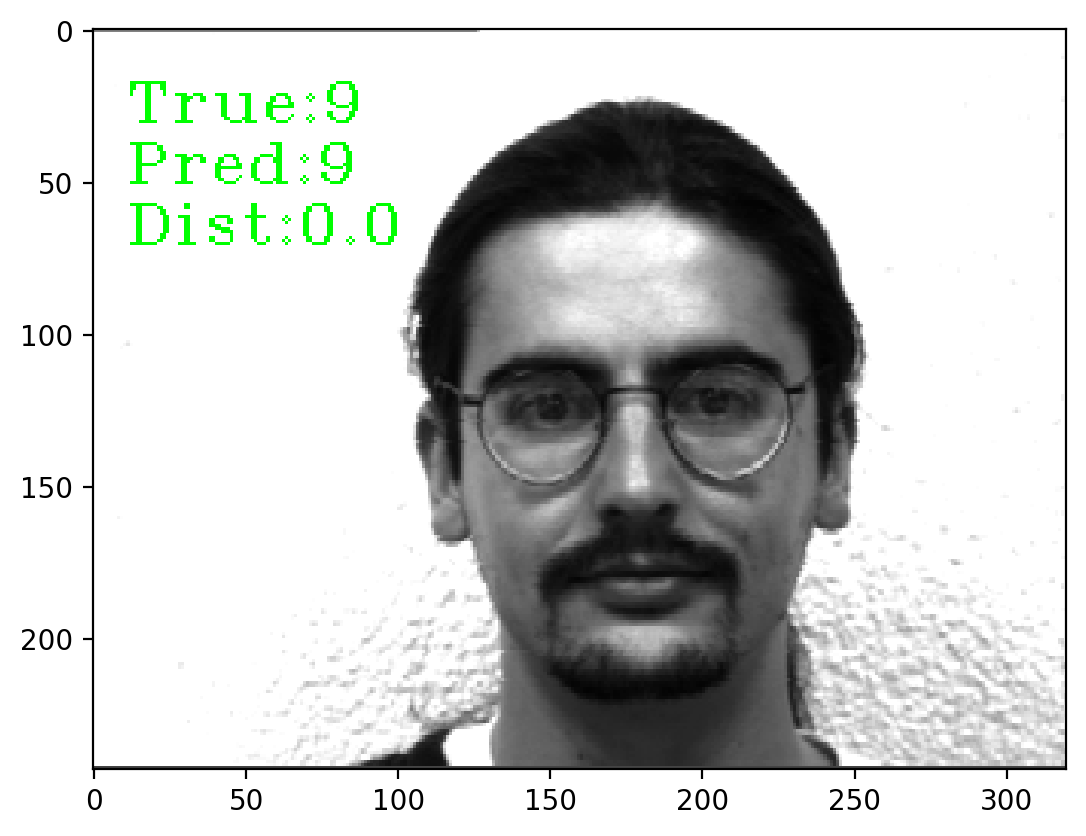

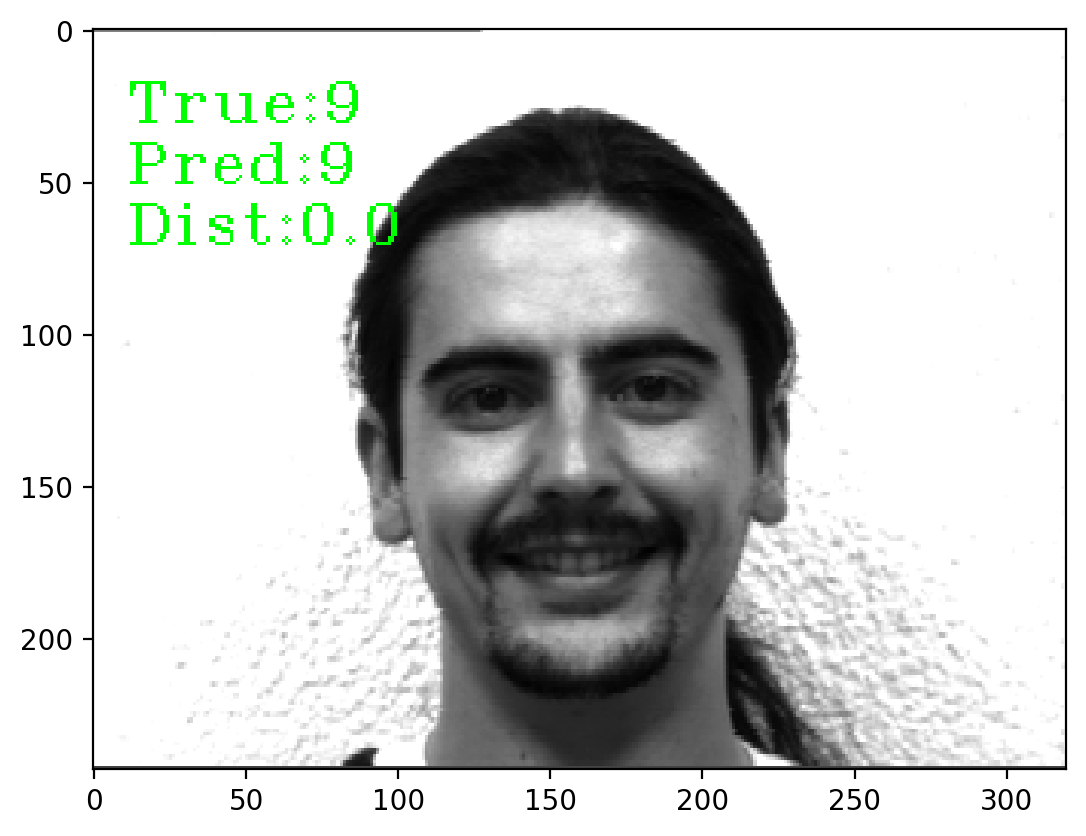

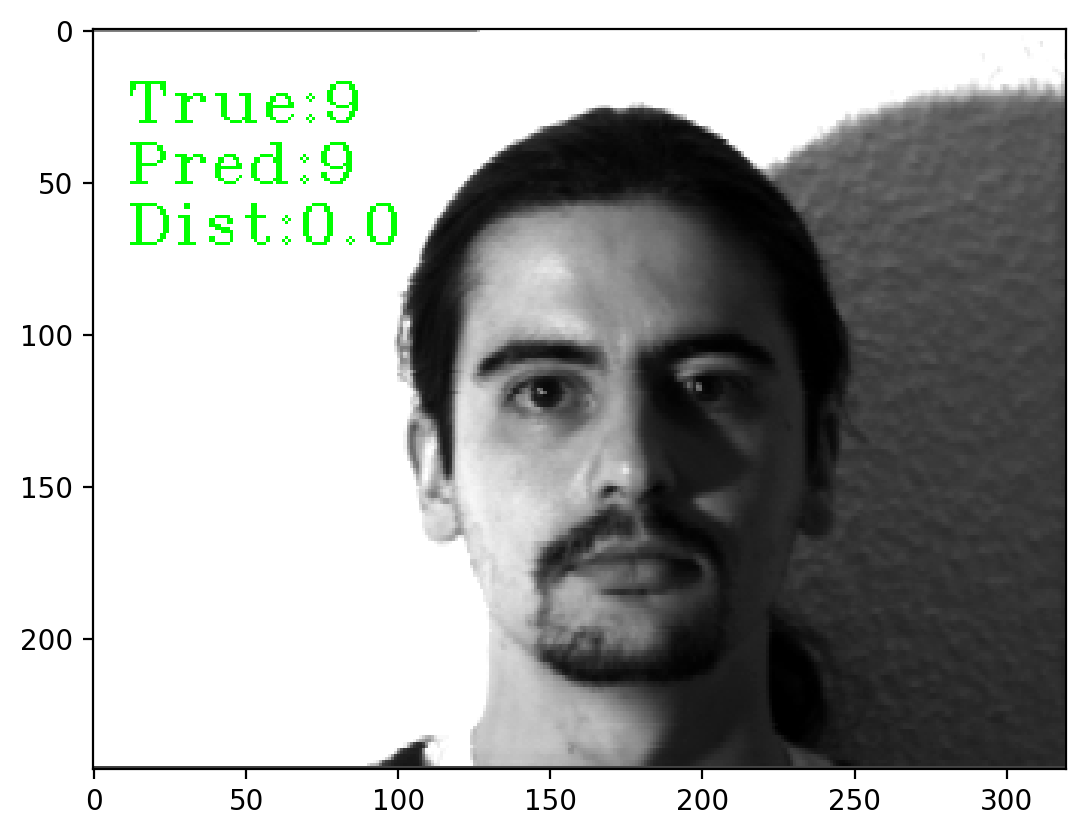

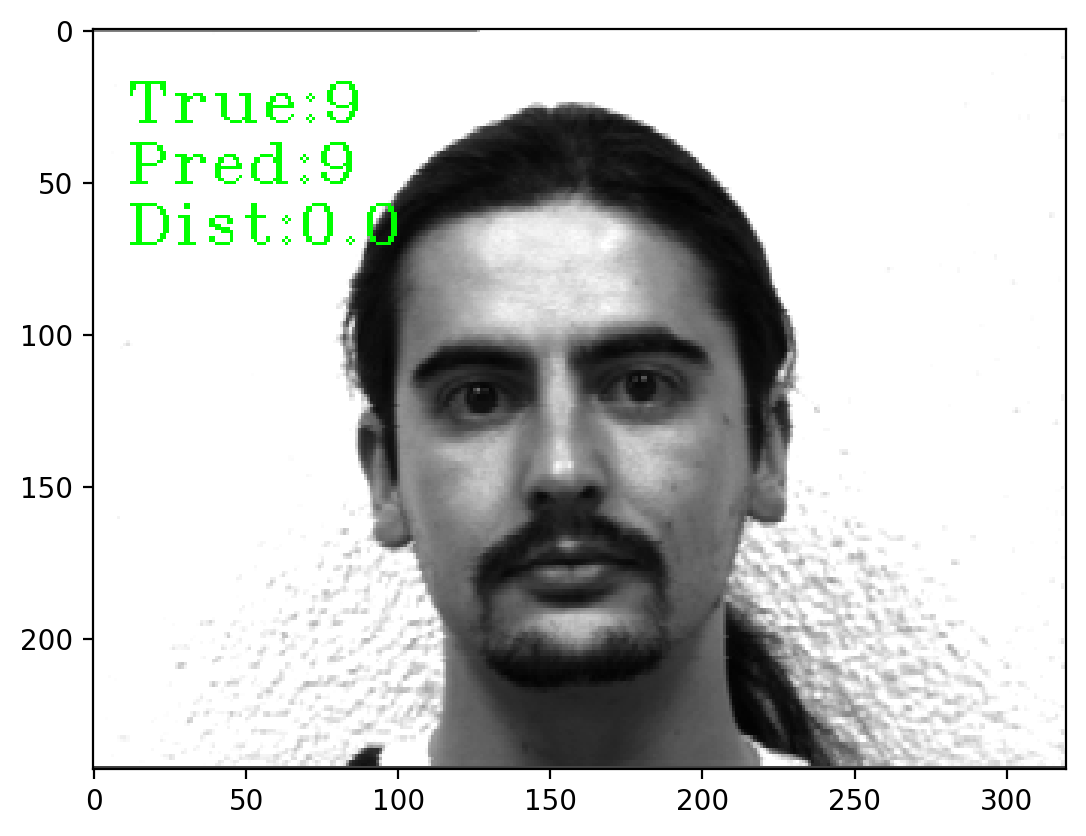

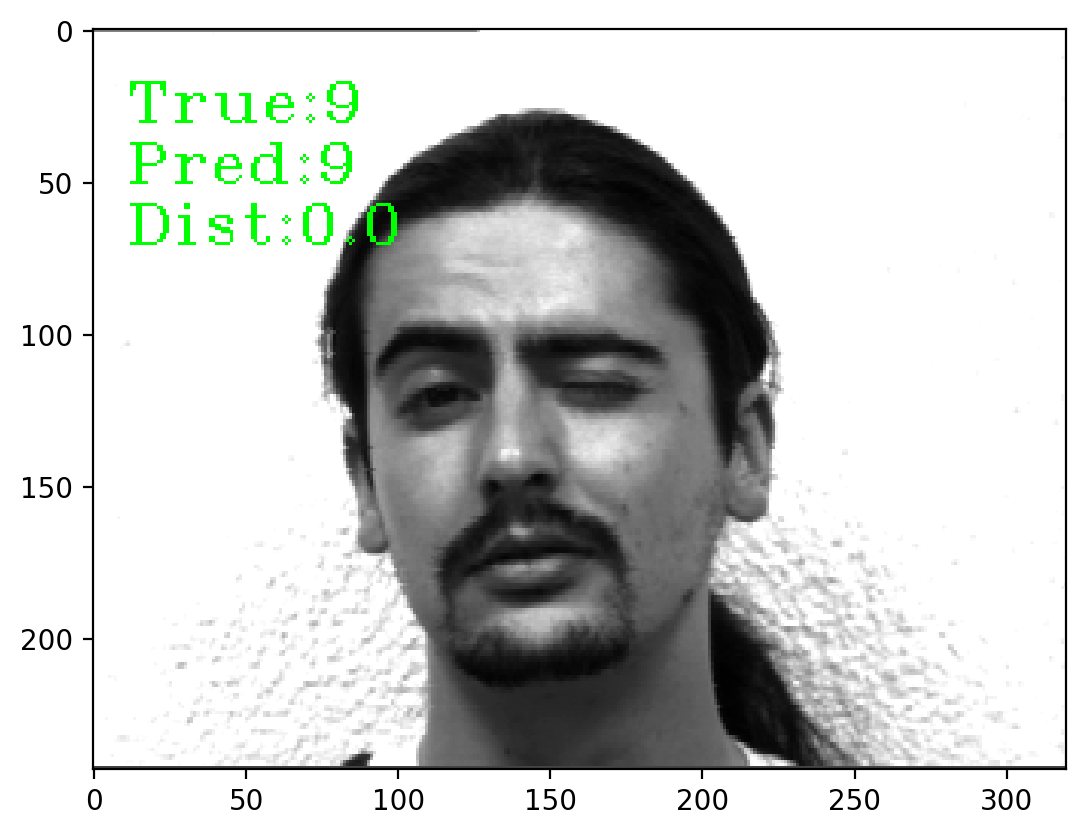

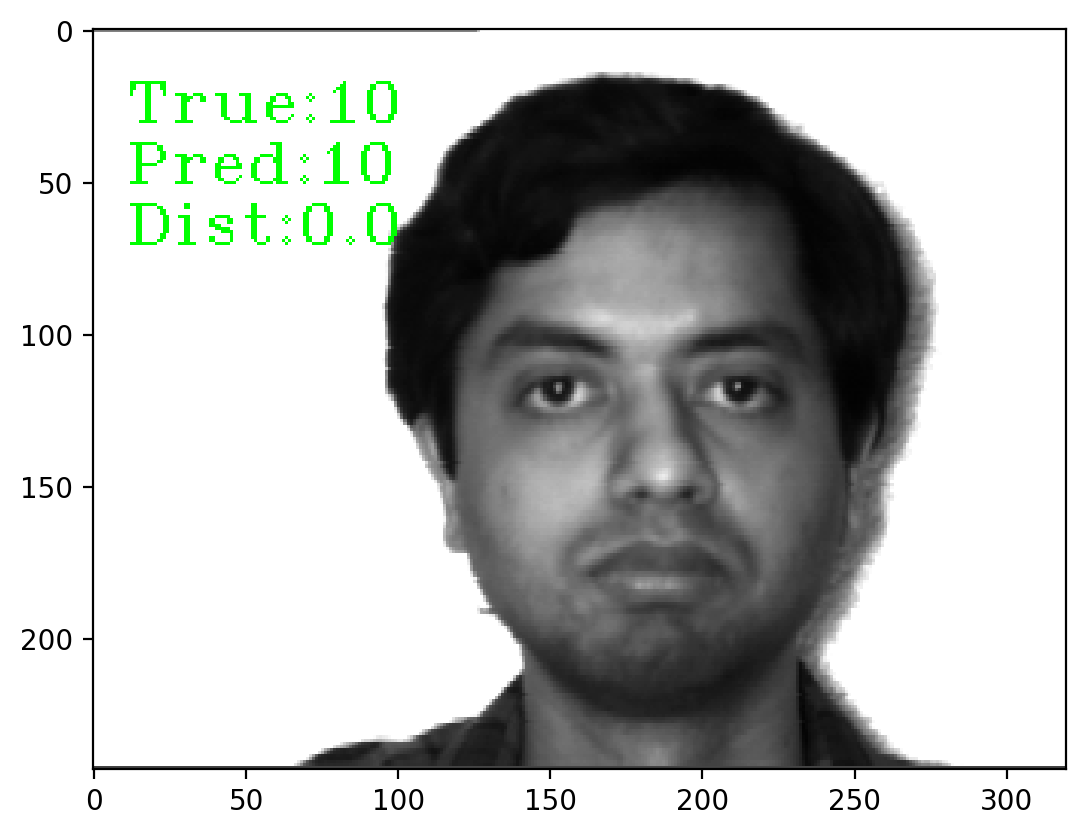

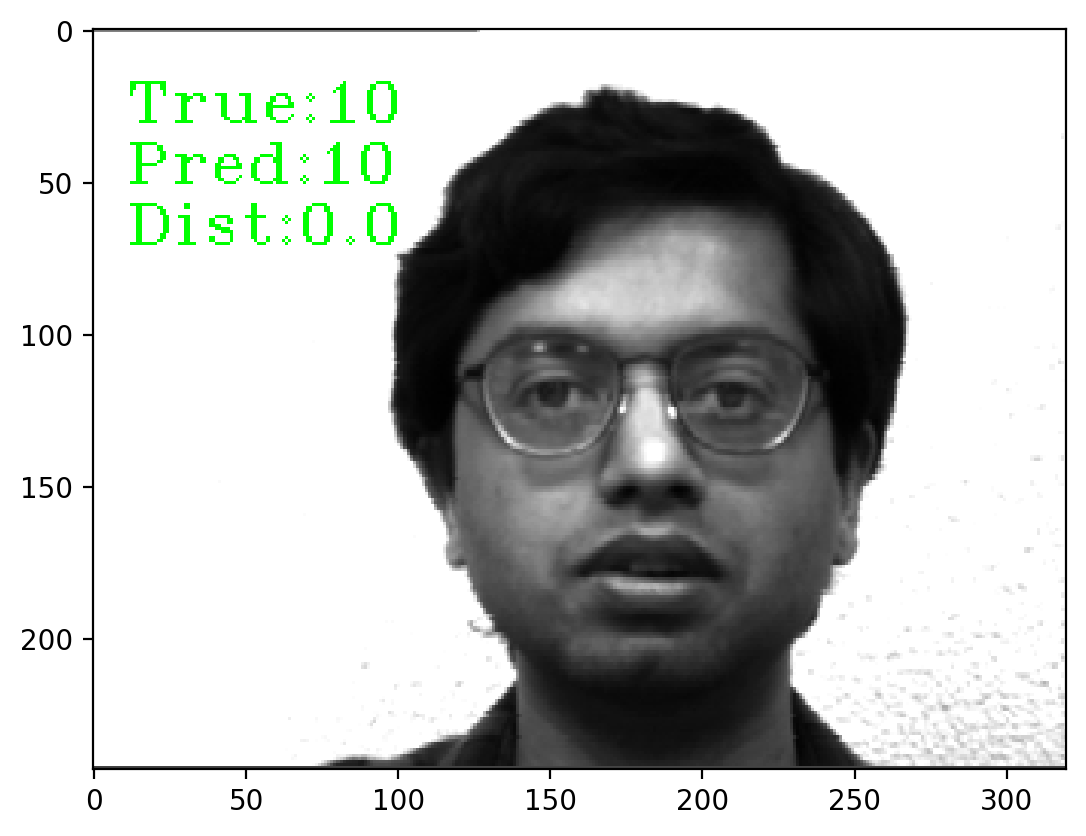

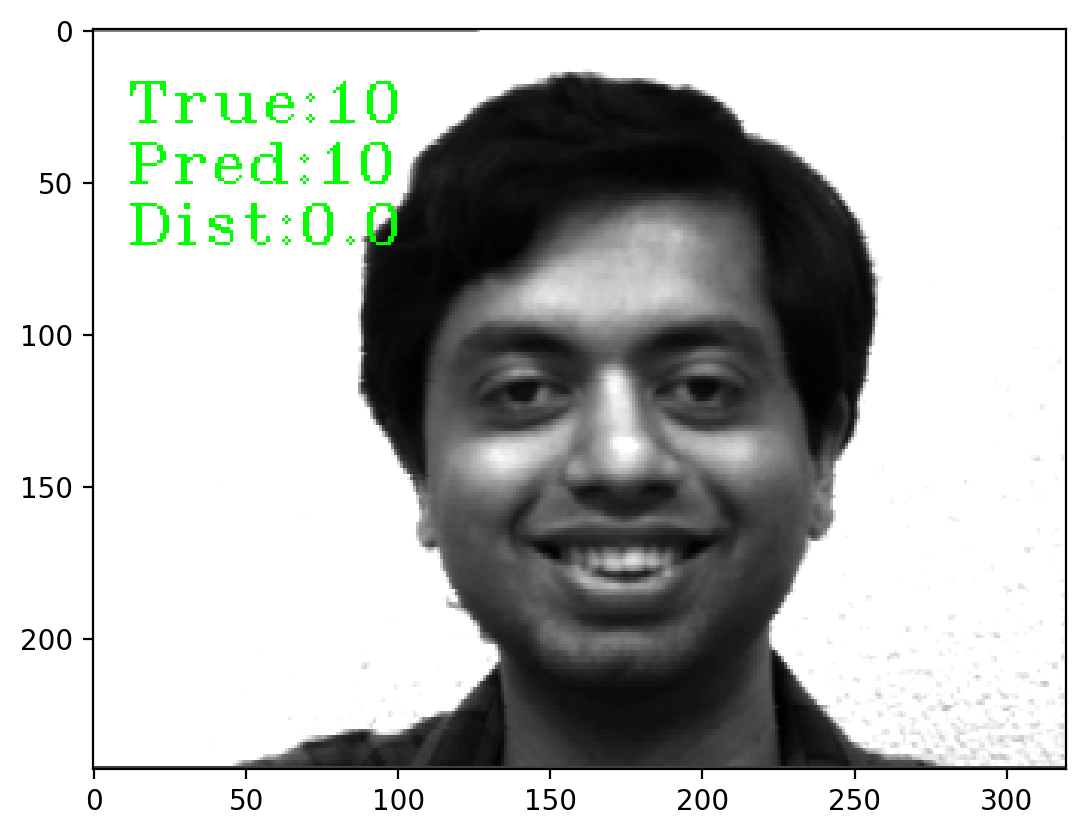

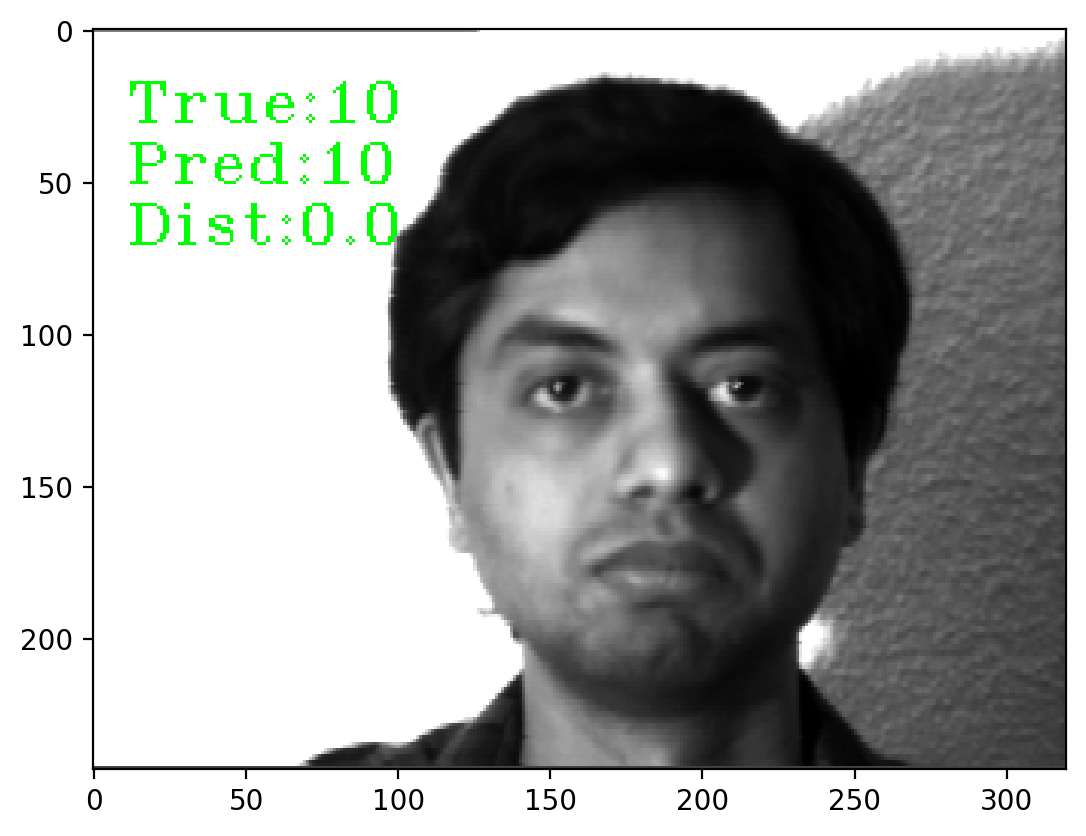

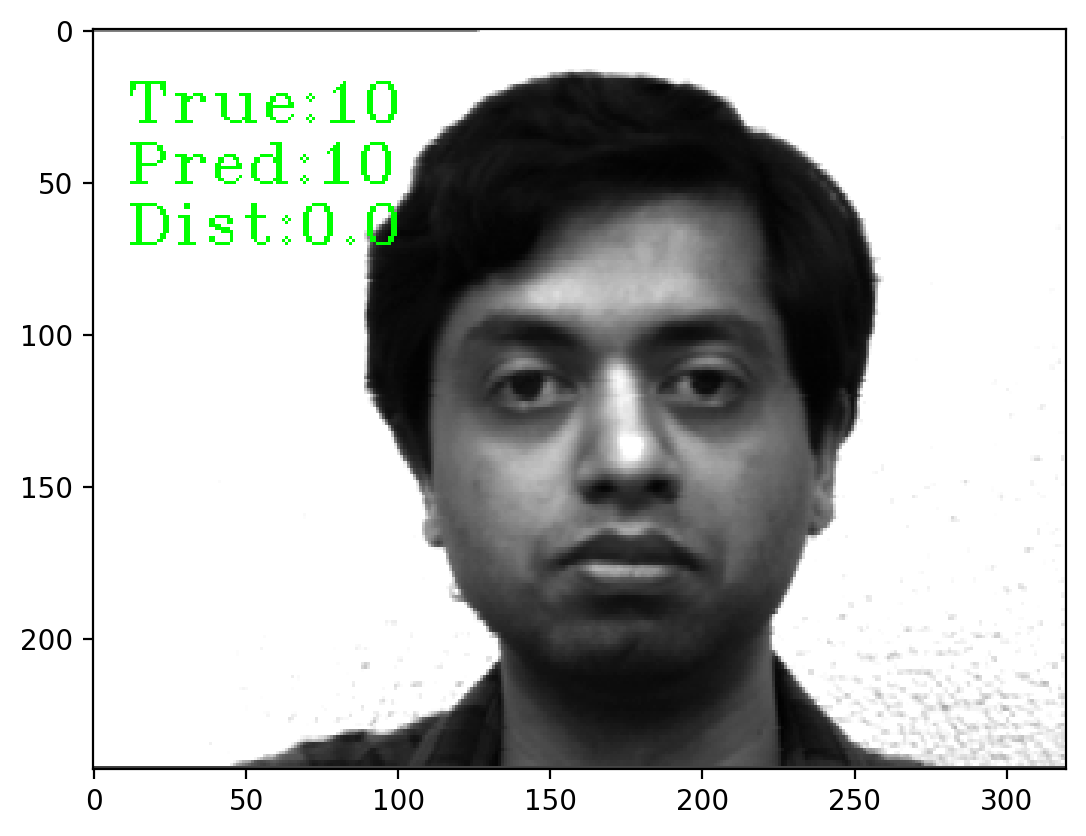

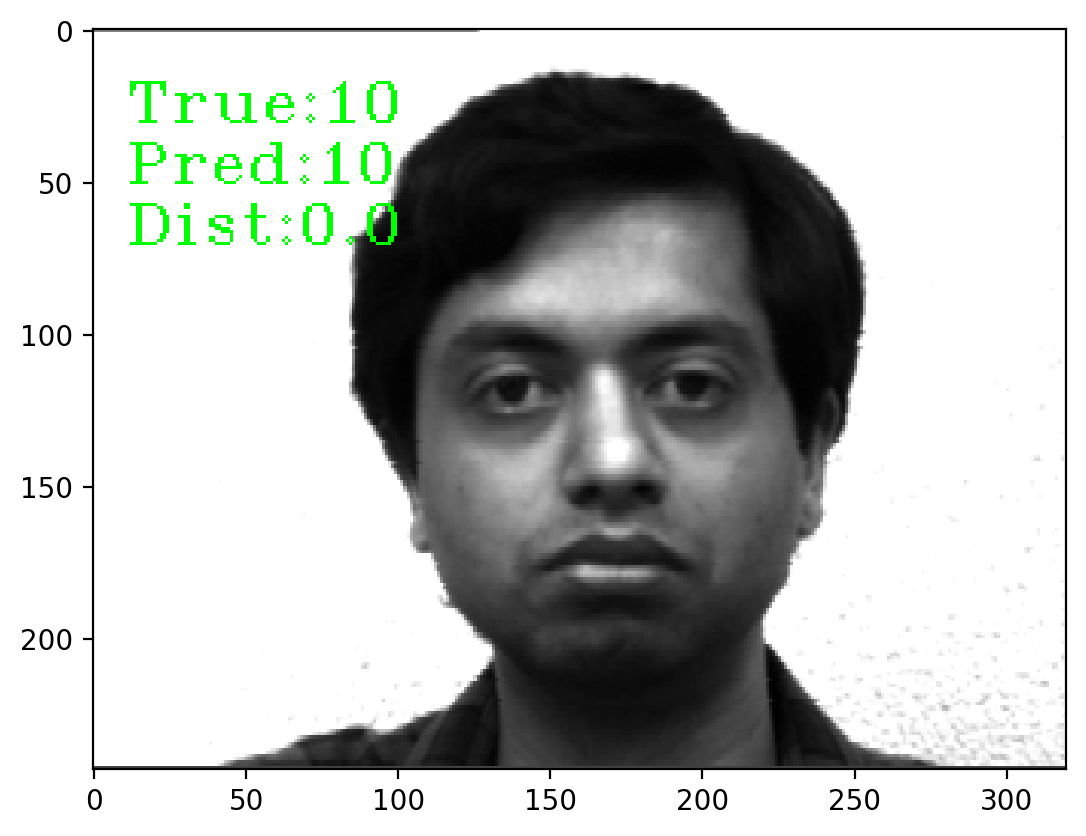

In [10]:
# 评估模型

import glob
file_list = glob.glob('./images/test/*.gif')
file_list = [file.replace('\\', '/') for file in file_list]

label_list = []
predict_list = []

# 距离阈值
threshold = 0.5

for file in file_list:
    label, feat = getFaceFeatLabel(file)
    
    cap = cv2.VideoCapture(file)
    ret,img = cap.read()

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    if feat is not None:
        # 计算距离
        distances = np.linalg.norm((feat-feature_list),axis=1)
        # 找最短距离
        min_index = np.argmin(distances)
        min_distance = distances[min_index]

        if min_distance < threshold:
            # 同一个人
            predict_id = int(name_list[min_index].split('/')[-1].split('.')[0].split('subject')[-1])
        else:
            predict_id = -1
    
        predict_list.append(predict_id)
        label_list.append(label)

        cv2.putText(img,'True:'+str(label),(10,30),cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(0,255,0))
        cv2.putText(img,'Pred:'+str(predict_id),(10,50),cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(0,255,0))
        cv2.putText(img,'Dist:'+str(min_distance),(10,70),cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(0,255,0))
        plt.figure()
        plt.imshow(img)

print(len(label_list))
print(len(predict_list))


In [11]:
# 公式评估
from sklearn.metrics import accuracy_score
accuracy_score(label_list,predict_list)


1.0